In [1]:
import pickle
import zipfile

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Batch, Data
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.optim as optim
from torch_geometric.loader import DataLoader

c:\Users\Anorm\anaconda3\envs\crystal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the datasets

with zipfile.ZipFile('CSD_GNN_DATA.zip') as zip: #large pkl were zipped to store on GitHub
    with zip.open('csd_GNN_DATA.pkl', 'r') as pkl:
        CSD_REAL = pickle.load(pkl)

with open('meoh_GNN_DATA.pkl', 'rb') as pkl:
    MEOH_DATA = pickle.load(pkl)

with open('acetam_GNN_DATA.pkl', 'rb') as pkl:
    ACETAM_DATA = pickle.load(pkl)

with zipfile.ZipFile('glutam_GNN_DATA.zip') as zip:
    with zip.open('glutam_GNN_DATA.pkl', 'r') as pkl:
        GLUTAM_DATA = pickle.load(pkl)

MEOH_DATA['Label'] = 0
ACETAM_DATA['Label'] = 0
GLUTAM_DATA['Label'] = 0

CSD_REAL['Label'] = 1

# Combine all dataframes
combined_df = pd.concat([CSD_REAL, MEOH_DATA, ACETAM_DATA, GLUTAM_DATA], ignore_index=True)

# Display the combined dataframe
print(combined_df.head())

  Structure                                        Descriptors  \
0  THGUAN10  [[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...   
1  HXACAN44  [[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...   
2  SUCROS46  [[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...   
3  HXACAN37  [[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...   
4  ESTRON03  [[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...   

                                         Coordinates  Label  
0  [[0.021195, 3.962655, 7.552919], [-0.4679856, ...      1  
1  [[4.5593728, 3.906487236, 5.7686352], [6.32379...      1  
2  [[0.2629282497, 8.7527061, 0.692916413], [-4.7...      1  
3  [[0.939546356, 3.966249972, -0.1263684], [2.08...      1  
4  [[0.7713405, 5.70425559, 7.3053992], [-1.84418...      1  


In [3]:
# Small sample of the combined dataframe

combined_df["Node Index"] = combined_df["Coordinates"].apply(lambda row: np.arange(0, len(row), 1))
small_df = combined_df.head(3)
small_df

,Structure,Descriptors,Coordinates,Label,Node Index
0,THGUAN10,"[[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...","[[0.021195, 3.962655, 7.552919], [-0.4679856, ...",1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,HXACAN44,"[[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...","[[4.5593728, 3.906487236, 5.7686352], [6.32379...",1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,SUCROS46,"[[6.0, 1.2010999999999998, 0.0, 0.0, 4.0, 1.7,...","[[0.2629282497, 8.7527061, 0.692916413], [-4.7...",1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [4]:
# Create edges

def build_distance_edges(coordinates, cutoff=5.0):
    """Construct edges based on Euclidean distance."""
    dist_matrix = cdist(coordinates, coordinates)  # Pairwise distances
    np.fill_diagonal(dist_matrix, np.inf)  # Ignore self-loops
    edges = np.argwhere(dist_matrix < cutoff)  # Edges as (i,j) pairs
    return edges  # Shape: [num_edges, 2]

# Example for the first molecule
coordinates = np.array(small_df.iloc[0]["Coordinates"])  # Shape: [num_atoms, 3]
edges = build_distance_edges(coordinates, cutoff=5.0) #cutoff in Angstroms, atoms more distant do not exchange information
print(edges)

[[  0  13]
 [  0  57]
 [  0 202]
 ...
 [538 523]
 [538 525]
 [538 534]]


In [5]:
# Create batch of graphs

graph_list = []
for idx in range(len(combined_df)):
    # Node features
    coords = combined_df['Coordinates'].to_numpy()[idx]
    descs = combined_df['Descriptors'].to_numpy()[idx]
    x = torch.tensor(np.concatenate([coords, descs], axis=1), dtype=torch.float32)
    y = torch.tensor([combined_df.iloc[idx]["Label"]], dtype=torch.float32)  ############## add label

    # Edges
    edges = build_distance_edges(coords, cutoff=5.0)  # edge-building function
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    # eg. tensor([[0, 1, 2],  # source nodes
    #             [1, 2, 0]]) # target nodes

    # Create Data object
    #graph_list.append(Data(x=x, edge_index=edge_index))
    graph_list.append(Data(x=x, edge_index=edge_index, y=y))

# Batch all graphs
batch = Batch.from_data_list(graph_list)
print("Batched data:", batch)

Batched data: DataBatch(x=[1562339, 26], edge_index=[2, 35162936], y=[2678], batch=[1562339], ptr=[2679])


In [6]:
# Stratified split

def stratified_split(graph_list):
    # Extract labels for stratification
    labels = [graph.y.item() for graph in graph_list]
    
    # Get indices for each class
    indices_class_0 = [i for i, label in enumerate(labels) if label == 0]
    indices_class_1 = [i for i, label in enumerate(labels) if label == 1]
    
    # Print class distribution
    print(f"Class 0: {len(indices_class_0)} samples")
    print(f"Class 1: {len(indices_class_1)} samples")
    
    # Split each class separately
    train_idx_0, temp_idx_0 = train_test_split(indices_class_0, test_size=0.4, random_state=42)
    val_idx_0, test_idx_0 = train_test_split(temp_idx_0, test_size=0.5, random_state=42)
    
    train_idx_1, temp_idx_1 = train_test_split(indices_class_1, test_size=0.4, random_state=42)
    val_idx_1, test_idx_1 = train_test_split(temp_idx_1, test_size=0.5, random_state=42)
    
    # Combine indices
    train_idx = train_idx_0 + train_idx_1
    val_idx = val_idx_0 + val_idx_1
    test_idx = test_idx_0 + test_idx_1
    
    # Create the datasets
    train_dataset = [graph_list[i] for i in train_idx]
    val_dataset = [graph_list[i] for i in val_idx]
    test_dataset = [graph_list[i] for i in test_idx]
    
    # Print split sizes
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    # Check class balance in splits
    train_labels = [graph.y.item() for graph in train_dataset]
    val_labels = [graph.y.item() for graph in val_dataset]
    test_labels = [graph.y.item() for graph in test_dataset]
    
    print(f"Train class balance - 0: {train_labels.count(0)}, 1: {train_labels.count(1)}")
    print(f"Val class balance - 0: {val_labels.count(0)}, 1: {val_labels.count(1)}")
    print(f"Test class balance - 0: {test_labels.count(0)}, 1: {test_labels.count(1)}")
    
    return train_dataset, val_dataset, test_dataset

# Apply the stratified split
train_dataset, val_dataset, test_dataset = stratified_split(graph_list)

Class 0: 797 samples
Class 1: 1881 samples
Train: 1606, Val: 535, Test: 537
Train class balance - 0: 478, 1: 1128
Val class balance - 0: 159, 1: 376
Test class balance - 0: 160, 1: 377


In [7]:
# Clean the features to handle NaN values

def clean_features(dataset):
    """Replace NaN values with zeros in each graph's features"""
    clean_dataset = []
    for data in dataset:
        clean_x = torch.nan_to_num(data.x, nan=0.0)
        clean_data = Data(
            x=clean_x,
            edge_index=data.edge_index,
            y=data.y
        )
        clean_dataset.append(clean_data)
    return clean_dataset

train_dataset = clean_features(train_dataset)
val_dataset = clean_features(val_dataset)
test_dataset = clean_features(test_dataset)

In [8]:
# Normalize features

def normalize_features(dataset):
    # Collect all features to compute statistics
    all_features = torch.cat([data.x for data in dataset], dim=0)
    mean = all_features.mean(dim=0, keepdim=True)
    std = all_features.std(dim=0, keepdim=True)
    std[std < 1e-5] = 1.0  # Avoid division by zero
    
    # Apply normalization to each graph
    normalized_dataset = []
    for data in dataset:
        # Make a copy of the data
        normalized_data = Data(
            x=(data.x - mean) / std,
            edge_index=data.edge_index,
            y=data.y
        )
        normalized_dataset.append(normalized_data)
    
    return normalized_dataset, mean, std

# Normalize training data and get statistics
train_dataset, feature_mean, feature_std = normalize_features(train_dataset)

# Apply the same normalization to validation and test
val_dataset_normalized = []
for data in val_dataset:
    val_dataset_normalized.append(Data(
        x=(data.x - feature_mean) / feature_std,
        edge_index=data.edge_index,
        y=data.y
    ))

test_dataset_normalized = []
for data in test_dataset:
    test_dataset_normalized.append(Data(
        x=(data.x - feature_mean) / feature_std,
        edge_index=data.edge_index,
        y=data.y
    ))

In [9]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_normalized, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset_normalized, batch_size=32, shuffle=False)

In [10]:
# GNN with batch normalization
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = torch.nn.Linear(hidden_channels // 2, hidden_channels // 4)
        self.lin3 = torch.nn.Linear(hidden_channels // 4, hidden_channels // 8)
        self.lin4 = torch.nn.Linear(hidden_channels // 8, 1)
        
        self.dropout = torch.nn.Dropout(0.3)
    
    def forward(self, x, edge_index, batch):
            
        # Node-level feature extraction
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = torch.relu(x)
        
        # Global mean pooling
        x = global_mean_pool(x, batch)
        
        # Graph-level classification
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.lin3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.lin4(x)
        
        return x

In [11]:
# Get the input dimension from the first graph in the training dataset
sample_data = train_dataset[0]
input_dim = sample_data.x.size(1)  # 26
print("Input dimension:", input_dim)

Input dimension: 26


## Load an existing model

In [16]:
model = GNN(input_dim=input_dim, hidden_channels=64)

checkpoint = torch.load('best_gnn_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

/var/folders/87/w9wc8z8x29vckh_y2y97hdg00000gn/T/ipykernel_98715/2892031285.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_gnn_model.pth')

<All keys matched successfully>

## Training a new model

In [12]:
# Create model with proper input dimension
model = GNN(input_dim=input_dim, hidden_channels=64)

# Weight initialization function
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, GCNConv):
        if hasattr(m, 'lin') and hasattr(m.lin, 'weight'):
            torch.nn.init.xavier_uniform_(m.lin.weight)
            if hasattr(m.lin, 'bias') and m.lin.bias is not None:
                m.lin.bias.data.fill_(0.01)

model.apply(init_weights)

# Use AdamW optimizer and learning rate
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_data in loader:
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch_data.x, batch_data.edge_index, batch_data.batch)

            
        # Compute loss
        loss = criterion(out.squeeze(), batch_data.y)
            
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Compute accuracy
        pred = torch.sigmoid(out) > 0.5
        correct += int((pred.squeeze() == batch_data.y).sum())
        total += batch_data.y.size(0)
        
        total_loss += loss.item() * batch_data.num_graphs
    
    return total_loss / len(loader.dataset), correct / total

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_data in loader:
            out = model(batch_data.x, batch_data.edge_index, batch_data.batch)
            loss = criterion(out.squeeze(), batch_data.y)
            
            pred = torch.sigmoid(out) > 0.5
            total_correct += int((pred.squeeze() == batch_data.y).sum())
            total += batch_data.y.size(0)
            
            total_loss += loss.item() * batch_data.num_graphs
    
    return total_loss / len(loader.dataset), total_correct / total

c:\Users\Anorm\anaconda3\envs\crystal\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Create lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop with early stopping
best_val_loss = float('inf')
patience = 15
counter = 0
best_model_state = None

for epoch in range(100):  
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = evaluate(model, val_loader)
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


Epoch 0, Train Loss: 0.5501, Train Acc: 0.7428, Val Loss: 0.3100, Val Acc: 0.9178
Epoch 1, Train Loss: 0.2960, Train Acc: 0.8854, Val Loss: 0.1329, Val Acc: 0.9570
Epoch 2, Train Loss: 0.1931, Train Acc: 0.9296, Val Loss: 0.0792, Val Acc: 0.9645
Epoch 3, Train Loss: 0.1584, Train Acc: 0.9340, Val Loss: 0.1133, Val Acc: 0.9589
Epoch 4, Train Loss: 0.1527, Train Acc: 0.9408, Val Loss: 0.0947, Val Acc: 0.9607
Epoch 5, Train Loss: 0.1276, Train Acc: 0.9533, Val Loss: 0.0853, Val Acc: 0.9607
Epoch 6, Train Loss: 0.1401, Train Acc: 0.9614, Val Loss: 0.0713, Val Acc: 0.9645
Epoch 7, Train Loss: 0.1208, Train Acc: 0.9608, Val Loss: 0.0785, Val Acc: 0.9645
Epoch 8, Train Loss: 0.1250, Train Acc: 0.9639, Val Loss: 0.0640, Val Acc: 0.9664
Epoch 9, Train Loss: 0.1033, Train Acc: 0.9701, Val Loss: 0.0671, Val Acc: 0.9664
Epoch 10, Train Loss: 0.1180, Train Acc: 0.9608, Val Loss: 0.0673, Val Acc: 0.9664
Epoch 11, Train Loss: 0.1116, Train Acc: 0.9645, Val Loss: 0.0714, Val Acc: 0.9664
Epoch 12, Trai

## Evaluate the model

In [14]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            # Forward pass
            out = model(batch.x, batch.edge_index, batch.batch)
            
            # Get predictions (sigmoid for binary classification)
            preds = (torch.sigmoid(out) > 0.5).float()
            
            # Track accuracy
            correct += (preds.squeeze() == batch.y).sum().item()
            total += batch.y.size(0)
            
            # Optional: Store predictions/labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Optional: Additional metrics (precision, recall, F1, ROC-AUC)
    from sklearn.metrics import classification_report, roc_auc_score
    print(classification_report(all_labels, all_preds))
    print(f"ROC-AUC: {roc_auc_score(all_labels, all_preds):.4f}")
    
    return accuracy

test_accuracy = test(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy:.2%}")


Test Accuracy: 0.9926
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       160
         1.0       1.00      0.99      0.99       377

    accuracy                           0.99       537
   macro avg       0.99      0.99      0.99       537
weighted avg       0.99      0.99      0.99       537

ROC-AUC: 0.9947
Final Test Accuracy: 99.26%


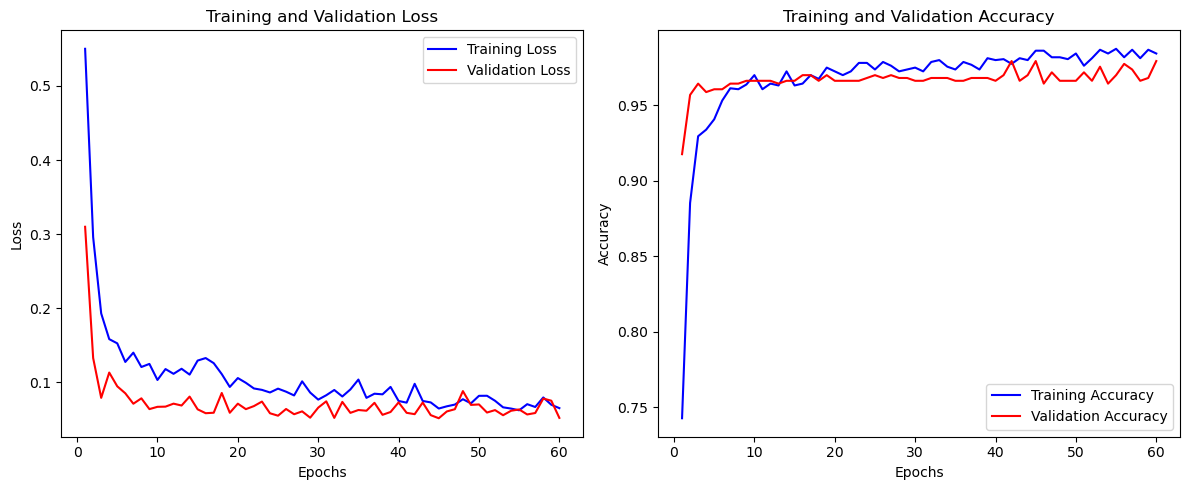

In [15]:
# Plot training and validation metrics
def plot_training_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Call the plotting function after training
plot_training_metrics(train_losses, val_losses, train_accs, val_accs)

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Evaluate on test set
#test_loss, test_acc = evaluate(model, test_loader)
#print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

## Save the model

In [ ]:
# Save the best model state
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': best_val_loss,
    'feature_stats': {'mean': feature_mean, 'std': feature_std}  # Save normalization stats
}, 'best_gnn_model.pth')

In [ ]:
torch.save(model.state_dict(), 'gnn_weights_only.pth')